In [1]:
import os
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import pickle

def dice_score(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice score between two binary masks.

    Args:
        y_true (numpy.ndarray): Ground truth binary mask.
        y_pred (numpy.ndarray): Predicted binary mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice score.
    """
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth) * 100

label_gt_path = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/labelsTs"
label_pred_path_deterministic = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/predictions/man_preds_deterministic"
label_pred_path_stochastic = "/scratch/awias/data/nnUNet/nnUNet_raw/Dataset004_TotalSegmentatorPancreas/predictions/man_preds_stochastic"

label_gt_file = [x for x in os.listdir(label_gt_path) if x.endswith(".nii.gz")]
label_pred_file = [x for x in os.listdir(label_pred_path_stochastic) if x.endswith(".nii.gz")]

all_subjects = [x.split('_')[0] for x in label_pred_file]

#Make sure the files are sorted in the same order
label_gt_file = sorted(label_gt_file, key=lambda x: x.split('_')[0])
label_pred_file = sorted(label_pred_file, key=lambda x: x.split('_')[1])

# if len(label_gt_file) != len(label_pred_file):
#     raise ValueError("Number of ground truth and prediction files do not match")

dice_diff_list = []
dice_stochastic_list = []
dice_deterministic_list = []

n = len(label_gt_file)

results_dict = {}

for subject in all_subjects:
    results_dict[subject] = {
        "dice_stochastic": None,
        "dice_deterministic": None,
        "dice_diff": None,
        "num_voxels_mask_gt": None
    }
    
results_pickle_path = "results_dict.pkl"

# Check if results_dict already exists
if os.path.exists(results_pickle_path):
    print("Found existing results_dict.pkl. Loading and skipping computation.")
    with open(results_pickle_path, "rb") as f:
        results_dict = pickle.load(f)
    skip_computation = True
else:
    skip_computation = False

if not skip_computation:
    for subject in all_subjects:
        try:
            mask_gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_gt_path, f"{subject}.nii.gz")))
            pred_stochastic = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_pred_path_stochastic, f"{subject}_0000_pred.nii.gz")))
            pred_deterministic = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(label_pred_path_deterministic, f"{subject}_0000_pred.nii.gz")))
            
            num_voxels_mask_gt = np.sum(mask_gt > 0)
            results_dict[subject]["num_voxels_mask_gt"] = num_voxels_mask_gt
            print(f"Subject {subject} has {num_voxels_mask_gt} voxels in GT mask.")

            # print(os.path.join(label_gt_path,label_gt_file[i]))
            # print(os.path.join(label_pred_path_stochastic,label_pred_file[i]))
            # tools.plot_central_slice_img_mask(mask_gt, pred, spacing=None)
            

            dice_stochastic = dice_score(mask_gt, pred_stochastic)
            dice_deterministic = dice_score(mask_gt, pred_deterministic)

            dice_diff = dice_stochastic - dice_deterministic

            results_dict[subject]["dice_stochastic"] = dice_stochastic
            results_dict[subject]["dice_deterministic"] = dice_deterministic
            results_dict[subject]["dice_diff"] = dice_diff
            
            # print(f"Dice diff for subject {subject} is: {dice_diff}")
        
        except:
            print(f"Error processing subject {subject}. Skipping...")
            
    # Save results_dict after computation
    with open(results_pickle_path, "wb") as f:
        pickle.dump(results_dict, f)
        



print("--------------------------------------------------")
print(f"Mean dice score (stochastic): {round(np.mean([v['dice_stochastic'] for v in results_dict.values()]), 3)}")
print(f"Median dice score (stochastic): {round(np.median([v['dice_stochastic'] for v in results_dict.values()]), 3)}")
print(f"Max dice score (stochastic): {round(np.max([v['dice_stochastic'] for v in results_dict.values()]), 3)}")
print(f"Min dice score (stochastic): {round(np.min([v['dice_stochastic'] for v in results_dict.values()]), 3)}")
print("--------------------------------------------------")

print(f"Mean dice score (deterministic): {round(np.mean([v['dice_deterministic'] for v in results_dict.values()]), 3)}")
print(f"Median dice score (deterministic): {round(np.median([v['dice_deterministic'] for v in results_dict.values()]), 3)}")
print(f"Max dice score (deterministic): {round(np.max([v['dice_deterministic'] for v in results_dict.values()]), 3)}")
print(f"Min dice score (deterministic): {round(np.min([v['dice_deterministic'] for v in results_dict.values()]), 3)}")
print("--------------------------------------------------")

print(f"Mean dice score difference: {round(np.mean([v['dice_diff'] for v in results_dict.values()]), 3)}")
print(f"Median dice score difference: {round(np.median([v['dice_diff'] for v in results_dict.values()]), 3)}")
print(f"Max dice score difference: {round(np.max([v['dice_diff'] for v in results_dict.values()]), 3)}")
print(f"Min dice score difference: {round(np.min([v['dice_diff'] for v in results_dict.values()]), 3)}")
print("--------------------------------------------------")


top_10_positive_diff = sorted(
    [(subject, v['dice_diff']) for subject, v in results_dict.items() if v['dice_diff'] is not None and v['dice_diff'] > 0],
    key=lambda x: x[1],
    reverse=True
)[:20]

print("Top 10 subjects with biggest positive dice_diff:")
for subject, diff in top_10_positive_diff:
    print(f"{subject}: Dice diff: {diff:.3f},  # voxels in GT mask: {results_dict[subject]['num_voxels_mask_gt']}")

Found existing results_dict.pkl. Loading and skipping computation.
--------------------------------------------------
Mean dice score (stochastic): 87.634
Median dice score (stochastic): 93.019
Max dice score (stochastic): 97.627
Min dice score (stochastic): 0.0
--------------------------------------------------
Mean dice score (deterministic): 86.346
Median dice score (deterministic): 91.786
Max dice score (deterministic): 97.588
Min dice score (deterministic): 0.0
--------------------------------------------------
Mean dice score difference: 1.287
Median dice score difference: 0.817
Max dice score difference: 46.74
Min dice score difference: -30.204
--------------------------------------------------
Top 10 subjects with biggest positive dice_diff:
215: Dice diff: 46.740,  # voxels in GT mask: 14
659: Dice diff: 20.000,  # voxels in GT mask: 6
976: Dice diff: 14.464,  # voxels in GT mask: 707
880: Dice diff: 11.868,  # voxels in GT mask: 6571
821: Dice diff: 11.512,  # voxels in GT ma

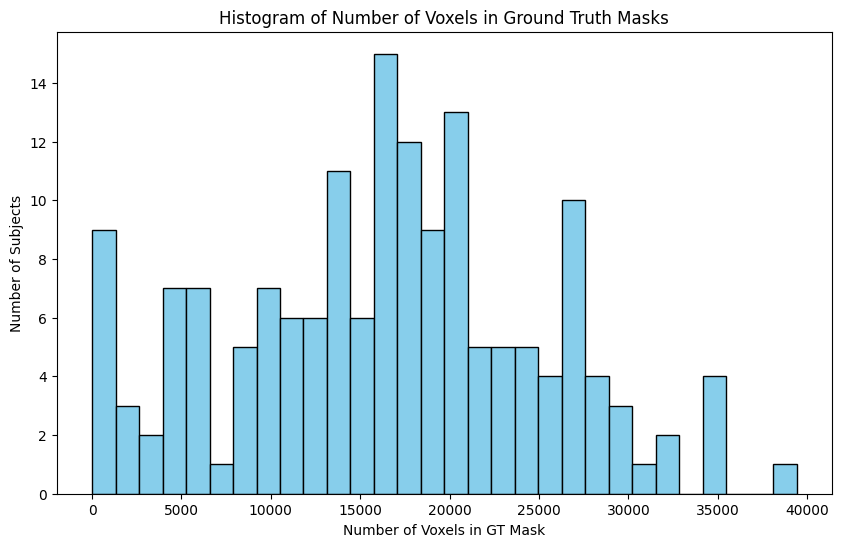

In [2]:
import matplotlib.pyplot as plt

num_voxels_list = [v['num_voxels_mask_gt'] for v in results_dict.values() if v['num_voxels_mask_gt'] is not None]

plt.figure(figsize=(10,6))
plt.hist(num_voxels_list, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Voxels in GT Mask')
plt.ylabel('Number of Subjects')
plt.title('Histogram of Number of Voxels in Ground Truth Masks')
plt.show()